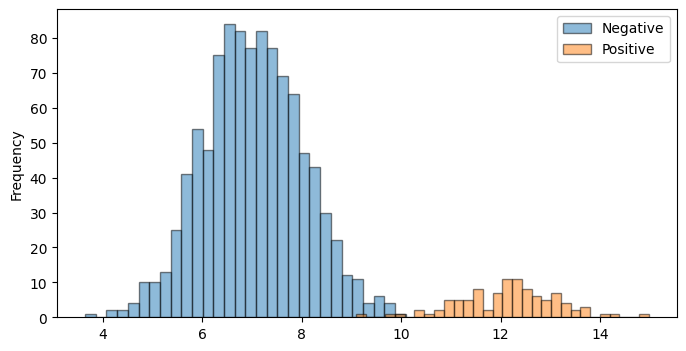

In [3]:
import numpy as np
import numpy.random as rn
import pandas as pd
import matplotlib.pyplot as plt

pos_center = 12
pos_count = 100
neg_center = 7
neg_count = 1000
rs = rn.RandomState(rn.MT19937(rn.SeedSequence(42)))
gini = pd.DataFrame({'value':
np.append((pos_center) + rs.randn(pos_count),
(neg_center) + rs.randn(neg_count)),
'label':
['pos']* pos_count + ['neg'] * neg_count})
fig, ax = plt.subplots(figsize=(8, 4))
_ = (gini
.groupby('label')
[['value']]
.plot.hist(bins=30, alpha=.5, ax=ax, edgecolor='black')
)
ax.legend(['Negative', 'Positive'])

In [4]:
gini.label.value_counts()

label
neg    1000
pos     100
Name: count, dtype: int64

In [5]:
def calc_gini(df, val_col, label_col, pos_val, split_point,debug=False):
    ge_split = df[val_col] >= split_point
    eq_pos = df[label_col] == pos_val
    tp = df[ge_split & eq_pos].shape[0]
    fp = df[ge_split & ~eq_pos].shape[0]
    tn = df[~ge_split & ~eq_pos].shape[0]
    fn = df[~ge_split & eq_pos].shape[0]
    pos_size = tp+fp
    neg_size = tn+fn
    total_size = len(df)
    if pos_size == 0:
        gini_pos = 0
    else:
        gini_pos = 1 - (tp/pos_size)**2 - (fp/pos_size)**2
    if neg_size == 0:
        gini_neg = 0
    else:
        gini_neg = 1 - (tn/neg_size)**2 - (fn/neg_size)**2
    
    weighted_avg = gini_pos * (pos_size/total_size) + \
    gini_neg * (neg_size/total_size)
    if debug:
        print(f'{gini_pos=:.3} {gini_neg=:.3} {weighted_avg=:.3}')
    return weighted_avg

In [6]:
calc_gini(gini, val_col='value', label_col='label', pos_val='pos', split_point=9.24, debug=True)

gini_pos=0.217 gini_neg=0.00202 weighted_avg=0.0241


0.024117224644432264

Text(0.5, 0, 'Split Point')

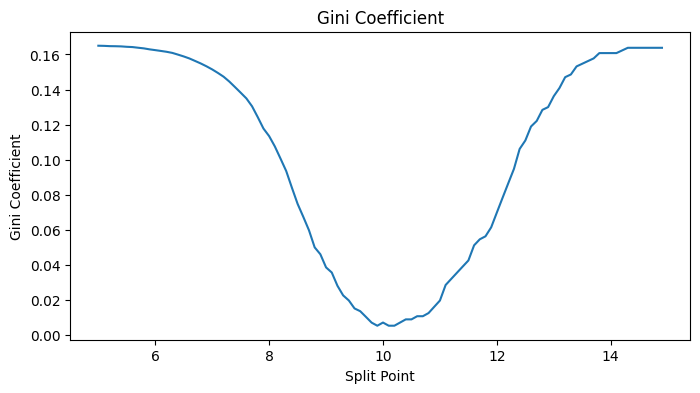

In [7]:
values = np.arange(5, 15, .1)
ginis = []
for v in values:
    ginis.append(calc_gini(gini, val_col='value', label_col='label',
    pos_val='pos', split_point=v))
    
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(values, ginis)
ax.set_title('Gini Coefficient')
ax.set_ylabel('Gini Coefficient')
ax.set_xlabel('Split Point')

In [8]:
pd.Series(ginis, index=values).loc[9.5:10.5]

9.6     0.013703
9.7     0.010470
9.8     0.007193
9.9     0.005429
10.0    0.007238
10.1    0.005438
10.2    0.005438
10.3    0.007244
10.4    0.009046
10.5    0.009046
dtype: float64

In [9]:
pd.DataFrame({'gini':ginis, 'split':values})

,gini,split
0,0.164968,5.0
1,0.164889,5.1
2,0.164730,5.2
3,0.164682,5.3
4,0.164584,5.4
...,...,...
95,0.163785,14.5
96,0.163785,14.6
97,0.163785,14.7
98,0.163785,14.8


In [10]:
print(pd.DataFrame({'gini':ginis, 'split':values}).query('gini <= gini.min()'))

        gini  split
49  0.005429    9.9
